## All Imports for the script

In [1]:
import h2o
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
import warnings
warnings.filterwarnings('ignore')
import json

import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd

In [2]:
# CONSTANT DECLARATIONS
AIRLINE_DATA_PATH = "C://repository/h2o_project/h2o_data/allyears2k.csv"

## Initiating h2o instance

In [3]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,7 hours 2 mins
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,13 days
H2O cluster name:,H2O_from_python_retim_d8mvtq
H2O cluster total nodes:,1
H2O cluster free memory:,45.59 Mb
H2O cluster total cores:,6
H2O cluster allowed cores:,6
H2O cluster status:,"locked, healthy"


##  Import the Airlines dataset

In [4]:
airline_df = h2o.import_file(AIRLINE_DATA_PATH)

Parse progress: |█████████████████████████████████████████████████████████| 100%


## Variable description

In [5]:
cat_features = ["Month", "DayofMonth", "DayOfWeek"]
target = "IsDepDelayed"

airline_df[target] = airline_df[target].asfactor()
for x in cat_features:
    airline_df[x] = airline_df[x].asfactor()

predictors = cat_features+ [ "UniqueCarrier", "Distance", "Dest"]

## Split the data set into a train (80%) and test set (20%)

In [6]:
train, valid = airline_df.split_frame(ratios = [.80,], seed = 1234)

## 1. Train a GBM with following parameters

In [7]:
# Train and validate a cartesian grid of GBMs
# 1,000 trees (specified; actual might be less because of early stopping)
# 3 stopping rounds
# 0.01 stopping tolerance
# Logloss stopping metric
# Model ID of gbm_model

gbm_model = H2OGradientBoostingEstimator(model_id = "gbm_model",
                                        ntrees = 1000,
                                        stopping_rounds = 3,
                                        stopping_tolerance = 0.01,
                                        stopping_metric = "logloss",
                                        seed = 1234)

gbm_model.train(x = predictors, 
                y = target,
                training_frame = train,
                validation_frame = valid
                )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [39]:
gbm_model.auc(valid = True)

0.683222499840106

In [22]:
#number of trees to build the model with early stopping
print("number of trees on gbm model: {}".format( gbm_model.score_history().iloc[-1]['number_of_trees']))

number of trees on gbm model: 12.0


## 2. Plot scoring history of the logloss

In [23]:
score_history = gbm_model.score_history()
score_history = pd.DataFrame(score_history)
print(score_history.columns)

Index(['', 'timestamp', 'duration', 'number_of_trees', 'training_rmse',
       'training_logloss', 'training_auc', 'training_pr_auc', 'training_lift',
       'training_classification_error', 'validation_rmse',
       'validation_logloss', 'validation_auc', 'validation_pr_auc',
       'validation_lift', 'validation_classification_error'],
      dtype='object')


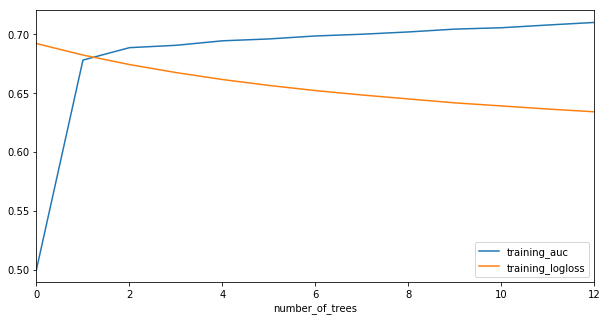

In [24]:
score_history.plot(x='number_of_trees' ,y = ['training_auc', 'training_logloss'], figsize=(10,5))
plt.show()

### print the validation logloss of the model

In [25]:
gbm_model.logloss(valid = True)

0.6440864391779298

### 3. Save the model

In [26]:
model_path_gbm = h2o.save_model(model=gbm_model, path="c://repository/h2o_project/gbm_model", force=True)

In [27]:
## saving POJO 
h2o.download_pojo(gbm_model, path = 'c://repository/h2o_project/gbm_model/', get_jar = True)

'c:\\repository\\h2o_project\\gbm_model\\gbm_model.java'

In [28]:
h2o.shutdown()

[WARNING] in <ipython-input-28-1edf85295eae> line 1:
    >>> h2o.shutdown()
        ^^^^ Deprecated, use ``h2o.cluster().shutdown()``.
H2O session _sid_a526 closed.


# B. Load Model, and Model Checkpointing

In [29]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.201-b09, mixed mode, sharing)
  Starting server from c:\programdata\miniconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\retim\AppData\Local\Temp\tmp4_pjjl8k
  JVM stdout: C:\Users\retim\AppData\Local\Temp\tmp4_pjjl8k\h2o_retim_started_from_python.out
  JVM stderr: C:\Users\retim\AppData\Local\Temp\tmp4_pjjl8k\h2o_retim_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,13 days
H2O cluster name:,H2O_from_python_retim_xsgxfw
H2O cluster total nodes:,1
H2O cluster free memory:,247.5 Mb
H2O cluster total cores:,6
H2O cluster allowed cores:,6
H2O cluster status:,"accepting new members, healthy"


## Variable declaration

In [30]:
#import data
airline_df = h2o.import_file("c://repository/h2o_project/h2o_data/allyears2k.csv")

# features data types
cat_features = ["Month", "DayofMonth", "DayOfWeek"]
target = "IsDepDelayed"

airline_df[target] = airline_df[target].asfactor()
for x in cat_features:
    airline_df[x] = airline_df[x].asfactor()

predictors = cat_features+ [ "UniqueCarrier", "Distance", "Dest"]

#split the data after determining all the data types on predictor 
train, valid = airline_df.split_frame(ratios = [.80,], seed = 1234)

Parse progress: |█████████████████████████████████████████████████████████| 100%


## 4. Load the GBM model

In [31]:
# load the model
saved_model = h2o.load_model("c://repository/h2o_project/gbm_model/gbm_model")

###  extracts the number of trees from the GBM model

In [46]:
saved_model.params['ntrees']

{'default': 50, 'actual': 1000}

Seems like this only hold default and passed but does not account for early stoppage, nevertheless can be found out differently

In [32]:
saved_model.score_history().iloc[-1].number_of_trees

12.0

## Continue building model with checkpoint adding 100 trees

In [47]:
# The following options cannot be modified when rebuilding a model using checkpoint:

# GBM/DRF Options

    # build_tree_one_node
    # max_depth
    # min_rows
    # nbins
    # nbins_cats
    # nbins_top_level
    # sample_rate

In [48]:
gbm_model_checkpoint = H2OGradientBoostingEstimator(model_id = 'gbm_model_checkpoint',
                                                    checkpoint = saved_model.model_id,
                                                    ntrees = (saved_model.params['ntrees']['actual'] + 100),
                                                    seed = 1234)

gbm_model_checkpoint.train(x = predictors, 
                y = target,
                training_frame = train,
                validation_frame = valid
                )

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [56]:
print ("auc saved model for training data: {:.3f}".format(saved_model.auc()))
print ("auc check point model for validation data: {:.3f}".format(gbm_model_checkpoint.auc(valid = True)))
print("number of trees to build checkpoint model: {:}".format(gbm_model_checkpoint.score_history().iloc[-1].number_of_trees))

auc saved model for training data: 0.710
auc check point model for validation data: 0.712
number of trees to build checkpoint model: 1100.0


### 6. Plot the scoring history of the logloss and print the validation logloss of the model that started training with the checkpoint.

In [57]:
score_history_checkpoint = gbm_model_checkpoint.score_history()
score_history_checkpoint = pd.DataFrame(score_history_checkpoint)
print(score_history_checkpoint.columns)

Index(['', 'timestamp', 'duration', 'number_of_trees', 'training_rmse',
       'training_logloss', 'training_auc', 'training_pr_auc', 'training_lift',
       'training_classification_error', 'validation_rmse',
       'validation_logloss', 'validation_auc', 'validation_pr_auc',
       'validation_lift', 'validation_classification_error'],
      dtype='object')


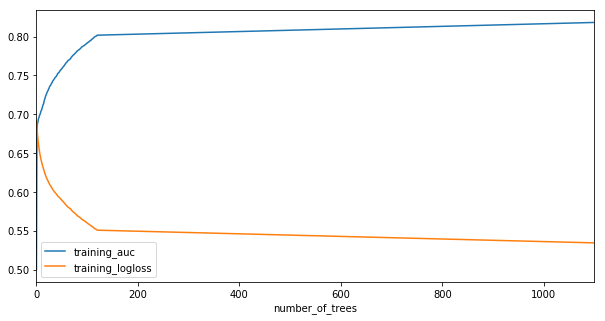

In [58]:
score_history_checkpoint.plot(x='number_of_trees' , y = ['training_auc', 'training_logloss'], figsize=(10,5))
plt.show()

In [59]:
h2o.cluster().shutdown()

H2O session _sid_b276 closed.
